<a href="https://colab.research.google.com/github/AeMcRa/Datascience-things/blob/main/AedaRamosU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install "preliz"


#Importing libraries! This code is copied from the notes.

import preliz as pz
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Average time to clear in my game
I am making a game with various levels that have difficulty that ranges from 1 to 5. Each level is relatively to uniform so a player's clear time on a difficulty of one level is relatively indicative of thier clear time on subsequent levels.

Because of this, the level's difficulties should catagorically inform the results of the subsequent levels, and I will use a hierarchical model to emulate this.

First, lets get our data. I played 100 levels to get this.

In [45]:
#getting raw file
url_time = 'https://raw.githubusercontent.com/AeMcRa/Datascience-things/refs/heads/main/LevelClearData.csv'

time_data = pd.read_csv(url_time,dtype={'difficulty':'category'})


In [46]:
#this is an array of the difficulty catagories,
#except they are given an int (number) label instead of a float (of numbers)
dif_idx = time_data.difficulty.cat.codes.values

#an array of the four strings that represent position
dif_codes = time_data.difficulty.cat.categories

#puts coords in a dict, so pymc can read them
dif_coords = {"dif": dif_codes}

(array([ 5.,  7., 21., 15., 12., 13.,  8.,  5.,  3.,  1.,  0.,  2.,  2.,
         1.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([ 3.897578 ,  7.8000546, 11.7025312, 15.6050078, 19.5074844,
        23.409961 , 27.3124376, 31.2149142, 35.1173908, 39.0198674,
        42.922344 , 46.8248206, 50.7272972, 54.6297738, 58.5322504,
        62.434727 , 66.3372036, 70.2396802, 74.1421568, 78.0446334,
        81.94711  ]),
 <BarContainer object of 20 artists>)

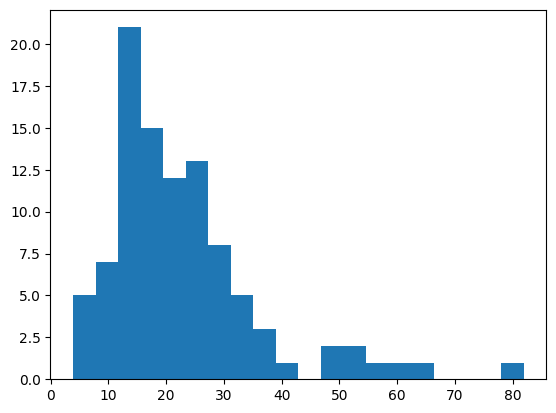

In [47]:
plt.hist(time_data.time,bins=20)

# Decisions and context

There are some critical things to know about both the game and the data before we continue. Most of these are based in the random generation of levels present in any given game.


1.   Difficulty catagories are fluid
  
    Difficulty catagories are player-facing metrics that refer to the fraction of the given game's maximum difficulty. The maximum difficulty increases based on the number of levels in a given game, so it is possible that a 'difficulty 1' level in a large game has the same true difficulty as a 'difficulty 2' level in a small game. Despite this, difficulty catagories are the information that the player is shown, and from a game design standpoint it is more useful for me to understand player perception as it relates to reality. A higher sample size of data will minimize the impact of this.
2.   You can lose
    
    When I began data collection I was presented with a choice. Either, I could turn off player damage and therefore losing, or keep it on. Turning it off would give me a more representative sample of the various level difficulties as each time I will make it though the entire game. However, I chose to keep it on. This is because I felt that being unable to be damaged would bias my gameplay and create unrealistic playpatterns and therefore results. The result of this is that I lost partway through the game on multiple occasions, which skewed data towards the lower difficulty catagories and since time data was only collected upon level win, I lost some incomplete data there. I do think this is reflective of reality however because players can in fact lose and will therefore play more levels at the begining of the game with lower difficulty.
    



3.   Level generation bugs

    In it's current state, the game posesses several generation bugs. Namely, Pathless Bound Error. This occurs when the map generates with inaccesisble levels, and each level's difficulty is set to 0. I disregarded this data as it wasn't useful.


# Prior Time!
I am using a gamma distribution for my likelihood because it is representative of the fact that time is only positive and data is concentrated towards the left due to the difficulty skew I mentioned prior. Gamma takes a mean and a standard distribution, which I used Gamma distributions for, since I feel that the gamma distribution is representative of my observations on how long levels tend to take and how much varience there is.

I'm using a pretty high standard distribution on my mean prior because I think that there is a lot of varience in level time.

My standard distribution prior is also decently sized for similar reasons.



<Axes: >

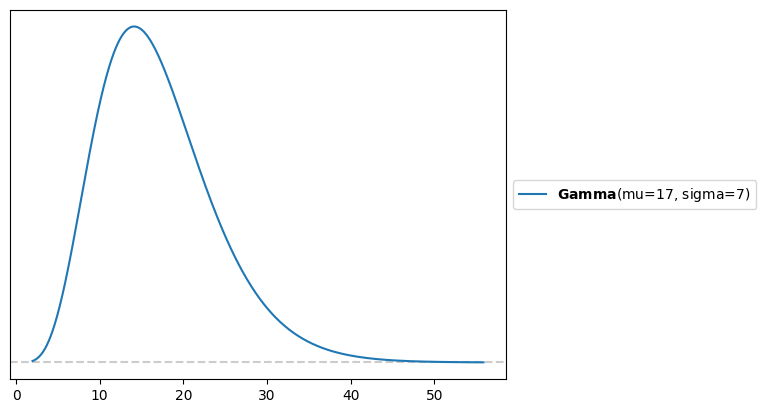

In [48]:
pz.Gamma( mu = 17, sigma = 7).plot_pdf()

<Axes: >

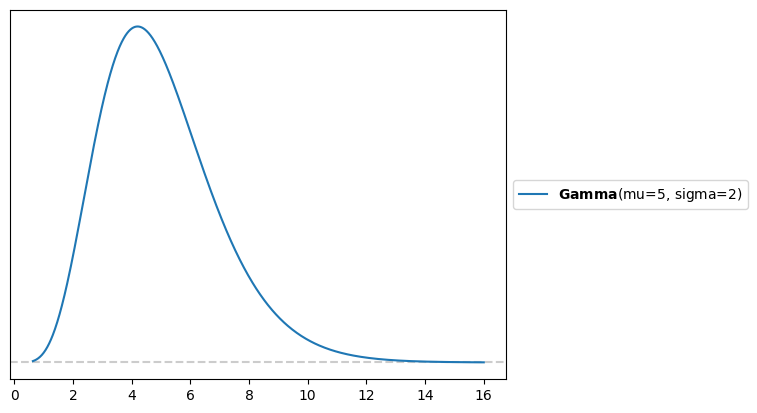

In [49]:
pz.Gamma( mu = 5, sigma = 2).plot_pdf()

In [50]:
#G for Gamma. This is our nonhierarchical model
with pm.Model(coords=dif_coords) as model_timeG:

    #mean prior
    μ = pm.Gamma('μ', mu = 17, sigma = 7,dims = "dif")

    σ = pm.Gamma('σ', mu = 5, sigma = 2,dims = "dif")


    #our likelihood, with one prior
    Y = pm.Gamma('Y', mu = μ[dif_idx], sigma = σ[dif_idx], observed=time_data.time)
    idata_timeG = pm.sample(target_accept = 0.95)

Output()

Output()

In [51]:
pm.sample_posterior_predictive(idata_timeG, model=model_timeG, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

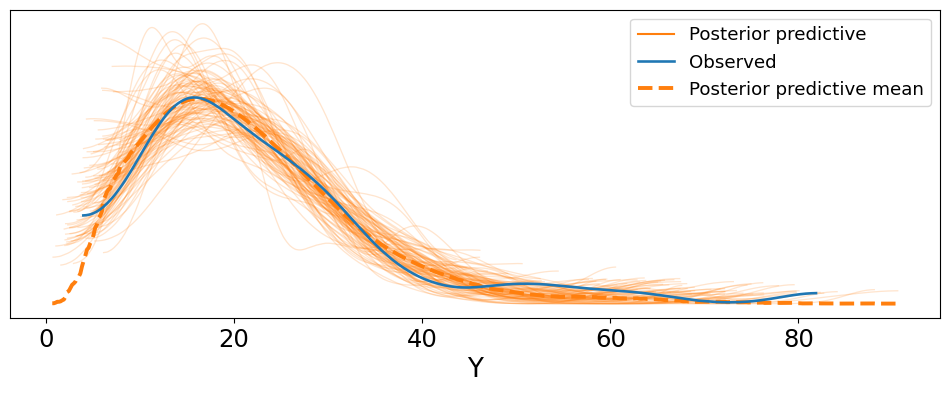

In [52]:
az.plot_ppc(idata_timeG, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Pretty Good!
I think the gamma distribution fits pretty well. But how would a hierarchical model compare?

# Hyperpriors

my hyper priors are pretty similar to the values of my mean prior as I saw that my mean prior was pretty solid.

In [53]:
with pm.Model(coords=dif_coords) as time_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all difficulties
    μ_mu = pm.Normal('μ_mu', mu = 17, sigma = 2)
    μ_sd = pm.Normal('μ_sd', mu= 5, sigma = 2)

    # priors. There is a different prior for each difficulty,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Gamma('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "dif")

    σ = pm.Gamma('σ', mu = 5,sigma = 2,
                      dims = "dif")

    #likelihood; same as before
    Y = pm.Gamma('Y',
                  mu = μ[dif_idx],
                  sigma = σ[dif_idx],
                  observed = time_data.time)

    #time for cleartime, h for heirarchical
    idata_time_h = pm.sample(target_accept = 0.95)

Output()

Output()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'μ_sd'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

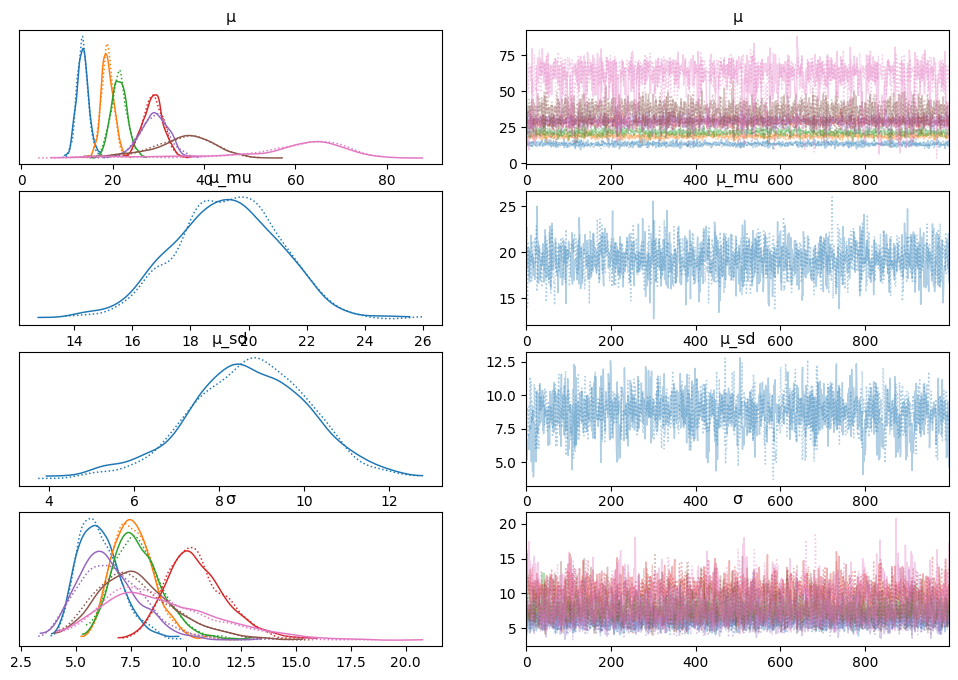

In [54]:
#this gives a visualization of what pymc was doing in those 6 to 8 minutes
az.plot_trace(idata_time_h)

In [55]:
az.rhat(idata_time_h)

<xarray.Dataset> Size: 212B
Dimensions:  (dif: 7)
Coordinates:
  * dif      (dif) <U3 84B '0.5' '1' '1.5' '2' '2.5' '3' '5'
Data variables:
    μ        (dif) float64 56B 1.001 1.002 1.0 1.002 1.001 0.9996 1.002
    μ_mu     float64 8B 1.001
    μ_sd     float64 8B 1.002
    σ        (dif) float64 56B 1.001 0.9999 0.9993 0.9998 1.003 1.0 1.004

# Everything looks good here, lets check the posterior.

In [56]:

pm.sample_posterior_predictive(idata_time_h, model=time_h_model, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

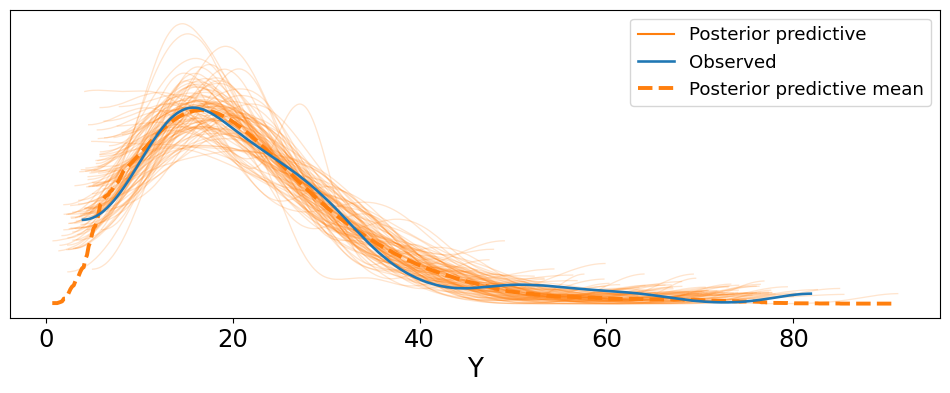

In [57]:
az.plot_ppc(idata_time_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# This is a lot better! Lets check our the catagories comparitevly


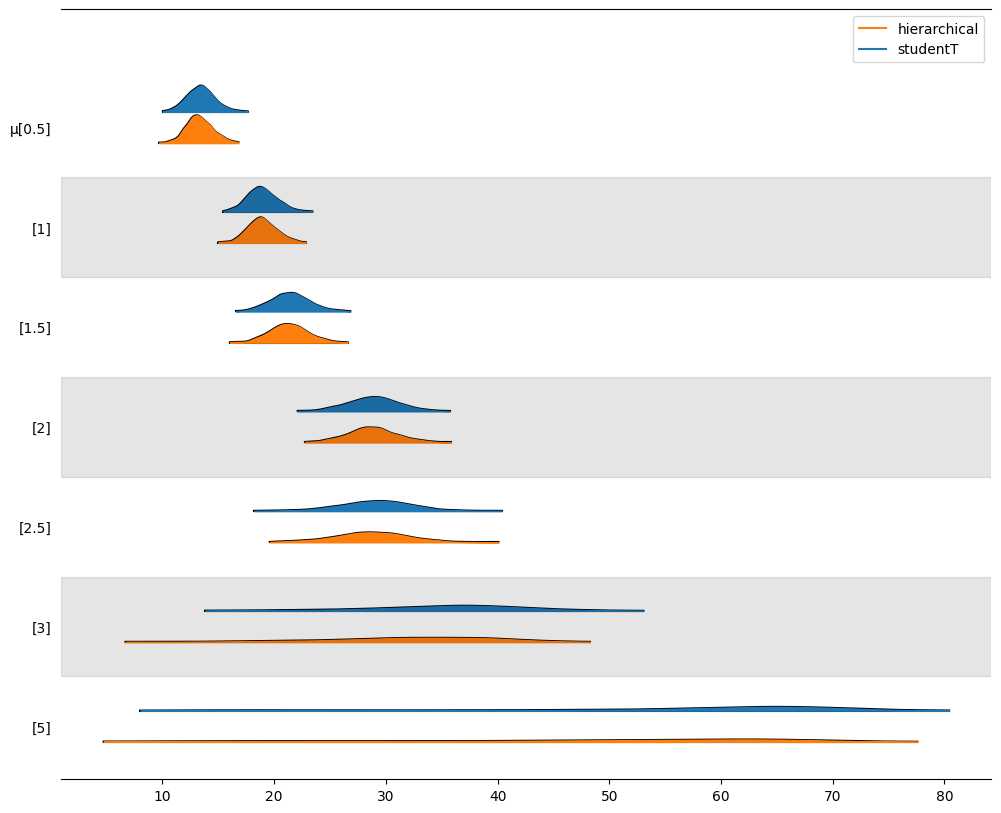

In [58]:
axes = az.plot_forest([idata_time_h, idata_timeG], kind="ridgeplot",
                      model_names=['studentT', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

# Looks like with our hierarchical model, it is skewed a bit to the left, but overall, not a huge impact

#One small thing however:
Difficulty 5 levels are technically not supposed to exist. These are our 'boss' levels, and will not exist in the final iteration. As a placeholder, we set them to max difficulty, which as we know from before is very variable. As such, I will omit them.

In [59]:
#more code from exercises
url_time = 'https://raw.githubusercontent.com/AeMcRa/Datascience-things/refs/heads/main/LevelClearData.csv'

time_data_nofive = pd.read_csv(url_time,dtype={'difficulty':'category'})

time_data_nofive = time_data_nofive[time_data_nofive.difficulty != '5']
time_data_nofive.difficulty = time_data_nofive.difficulty.cat.remove_categories('5')

In [60]:
#this is an array of the difficulty catagories,
#except they are given an int (number) label instead of a float (of numbers)
dif_idx_nofive = time_data_nofive.difficulty.cat.codes.values

#an array of the four strings that represent position
dif_codes_nofive = time_data_nofive.difficulty.cat.categories

#puts coords in a dict, so pymc can read them
dif_coords_nofive = {"dif": dif_codes_nofive}

In [61]:


#this is an array of the difficulty catagories,
#except they are given an int (number) label instead of a float (of numbers)
dif_idx_nofive = time_data_nofive.difficulty.cat.codes.values

#an array of the four strings that represent position
dif_codes_nofive = time_data_nofive.difficulty.cat.categories

#puts coords in a dict, so pymc can read them
dif_coords_nofive = {"dif": dif_codes_nofive}

with pm.Model(coords=dif_coords_nofive) as time_h_model_nofive:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all difficulties
    μ_mu = pm.Normal('μ_mu', mu = 17, sigma = 2)
    μ_sd = pm.Normal('μ_sd', mu= 5, sigma = 3)

    # priors. There is a different prior for each difficulty,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Gamma('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "dif")

    σ = pm.Gamma('σ', mu = 5,sigma = 2,
                      dims = "dif")

    #likelihood; same as before
    Y = pm.Gamma('Y',
                  mu = μ[dif_idx_nofive],
                  sigma = σ[dif_idx_nofive],
                  observed = time_data_nofive.time)

    #time for cleartime, h for heirarchical
    idata_time_h_nofive = pm.sample(target_accept = 0.95)




Output()

Output()

ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'μ_sd'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

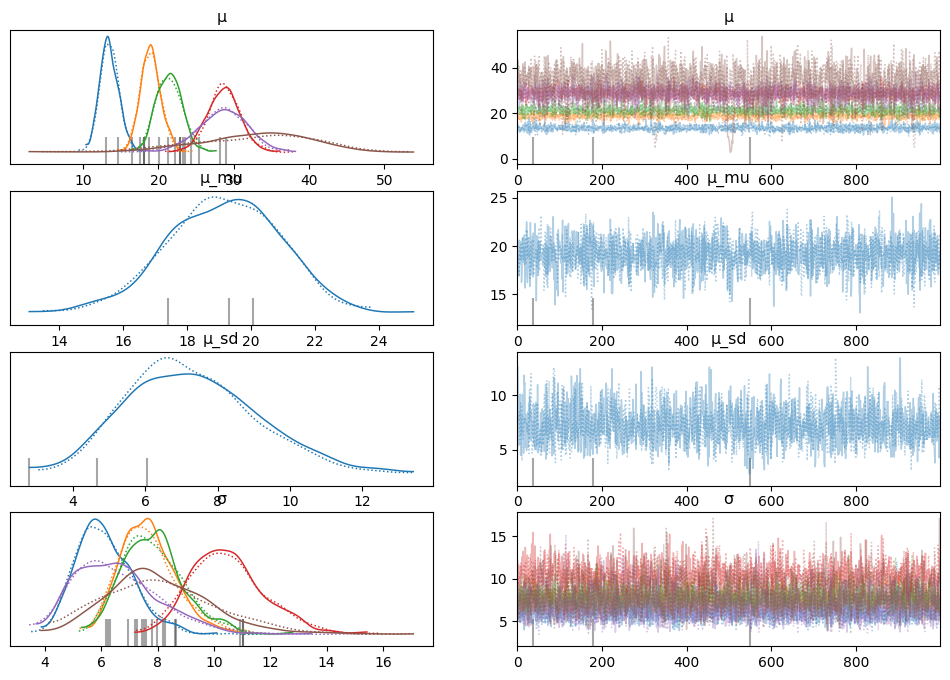

In [62]:
az.plot_trace(idata_time_h_nofive)

In [63]:
az.rhat(idata_time_h_nofive)

<xarray.Dataset> Size: 184B
Dimensions:  (dif: 6)
Coordinates:
  * dif      (dif) <U3 72B '0.5' '1' '1.5' '2' '2.5' '3'
Data variables:
    μ        (dif) float64 48B 1.001 0.9997 1.001 1.003 1.002 1.01
    μ_mu     float64 8B 1.0
    μ_sd     float64 8B 1.002
    σ        (dif) float64 48B 1.0 1.002 0.9998 1.001 1.001 1.004

# rhat values are looking better now. Lets get our final posterior and compare.

In [64]:
#az.plot_ppc(idata_time_h_nofive, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
pm.sample_posterior_predictive(idata_time_h_nofive, model=time_h_model_nofive, extend_inferencedata=True)




Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

# Hierarchical

<Axes: xlabel='Y'>

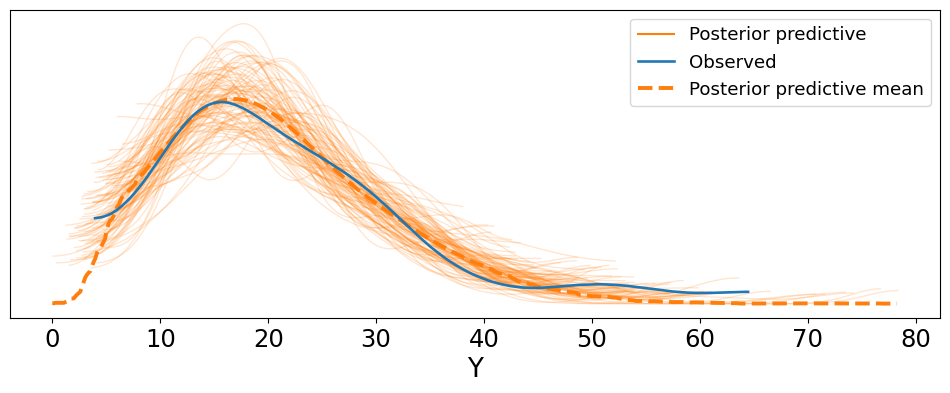

In [65]:
az.plot_ppc(idata_time_h_nofive, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

#Nonheirarchical

<Axes: xlabel='Y'>

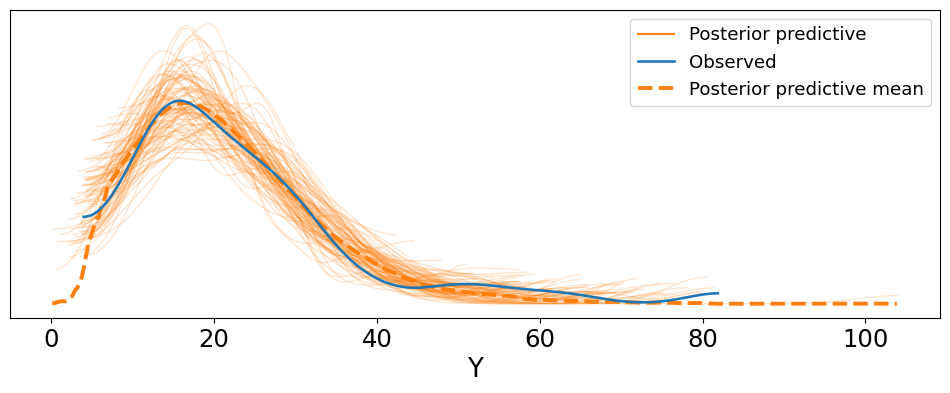

In [66]:
az.plot_ppc(idata_timeG, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# One more catagorical comparison

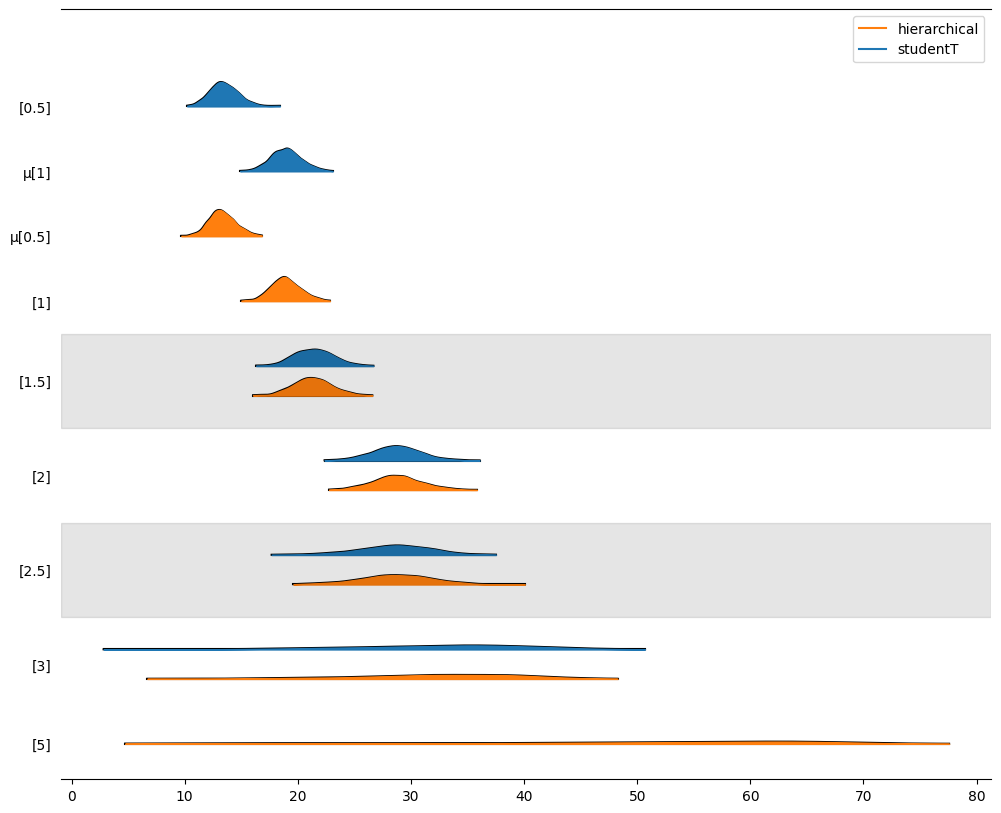

In [67]:
axes = az.plot_forest([idata_time_h_nofive, idata_timeG], kind="ridgeplot",
                      model_names=['studentT', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

# Final thoughts
As we can see, the hierarchical model was slightly better for my data, but didn't have a huge impact. I think my main issue now is simply volume of data, and if I played video games for 2 more hours it would be even better.